### Load necessary files and packages

In [16]:
from google.colab import files
uploaded = files.upload()

Saving weights_pretrained.zip to weights_pretrained.zip


In [ ]:
!unzip "weights_pretrained.zip"

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from sklearn.preprocessing import LabelEncoder
import idx2numpy

### Create Dataset

In [2]:
ROOT_DIR = 'mnistTask'
labels = []
images = []
all_labels = os.listdir(ROOT_DIR)
for label in all_labels:
  path = [os.path.join(ROOT_DIR, label, p) for p in os.listdir(os.path.join(ROOT_DIR, label))]
  for p in path:
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (28, 28))
    images.append(image)
    labels.append(int(label))

In [3]:
images = np.asarray(images)/255
images = np.expand_dims(images, -1)
labels = np.asarray(labels)

In [4]:
images.shape, labels.shape

((60000, 28, 28, 1), (60000,))

### Train-Validation Split
#### Test set is loaded from MNIST dataset

In [5]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

file = 't10k-images-idx3-ubyte'
x_test = idx2numpy.convert_from_file(file)

file = 't10k-labels-idx1-ubyte'
y_test = idx2numpy.convert_from_file(file)

x_train.shape, y_train.shape

((48000, 28, 28, 1), (48000,))

### Model Creation & Training

In [6]:
def Model(image, label, dropout=0.25):
  _input = tf.keras.layers.Input(shape=image)

  x = tf.keras.layers.Conv2D(16, (3, 3))(_input)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Conv2D(32, (3, 3))(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Conv2D(64, (3, 3))(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  # x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(256)(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(128)(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(label)(x)
  x = tf.keras.layers.Activation(tf.nn.softmax)(x)
  return tf.keras.Model(_input, x)

Summary of the model

In [7]:
model = Model(x_train[0].shape, 10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640  

In [8]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_scratch/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/200
188/188 [==============================] - 6s 13ms/step - loss: 2.7407 - accuracy: 0.1056 - val_loss: 2.4233 - val_accuracy: 0.1053
Epoch 2/200
188/188 [==============================] - 2s 9ms/step - loss: 2.3713 - accuracy: 0.1113 - val_loss: 2.3727 - val_accuracy: 0.1034
Epoch 3/200
188/188 [==============================] - 2s 9ms/step - loss: 2.3068 - accuracy: 0.1134 - val_loss: 2.3090 - val_accuracy: 0.1108
Epoch 4/200
188/188 [==============================] - 2s 9ms/step - loss: 2.2741 - accuracy: 0.1154 - val_loss: 2.2681 - val_accuracy: 0.1157
Epoch 5/200
188/188 [==============================] - 2s 9ms/step - loss: 2.2557 - accuracy: 0.1173 - val_loss: 2.2451 - val_accuracy: 0.1141
Epoch 6/200
188/188 [==============================] - 2s 9ms/step - loss: 2.2482 - accuracy: 0.1160 - val_loss: 2.2510 - val_accuracy: 0.1156
Epoch 7/200
188/188 [==============================] - 2s 9ms/step - loss: 2.2403 - accuracy: 0.1175 - val_loss: 2.2511 - val_accuracy: 0.113

Plot of the train history (X-axis: <i>EPOCHS</i>, Y-axis: <i>ACCURACY</i>)

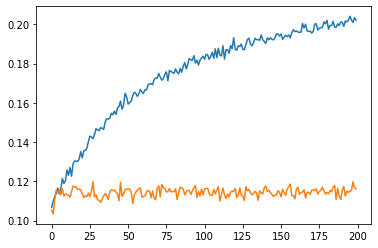

In [9]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

In [10]:
model.load_weights('weights_scratch/')
print("Train Accuracy:", model.evaluate(x_train, y_train, verbose=0)[1], "Test Accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Train Accuracy: 0.1666666716337204 Test Accuracy: 0.0005000000237487257


### Train on pre-trained model

In [14]:
model.load_weights("weights_pretrained/")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='MNIST_pretrained/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = model.fit(x_train, y_train, validation_split=0.25, epochs=200, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/200
141/141 [==============================] - 1s 10ms/step - loss: 3.7556 - accuracy: 0.1050 - val_loss: 2.4259 - val_accuracy: 0.1153
Epoch 2/200
141/141 [==============================] - 1s 10ms/step - loss: 2.5908 - accuracy: 0.1099 - val_loss: 2.2821 - val_accuracy: 0.1115
Epoch 3/200
141/141 [==============================] - 1s 9ms/step - loss: 2.4512 - accuracy: 0.1113 - val_loss: 2.2796 - val_accuracy: 0.1104
Epoch 4/200
141/141 [==============================] - 1s 9ms/step - loss: 2.3910 - accuracy: 0.1131 - val_loss: 2.2857 - val_accuracy: 0.1085
Epoch 5/200
141/141 [==============================] - 1s 9ms/step - loss: 2.3551 - accuracy: 0.1151 - val_loss: 2.2744 - val_accuracy: 0.1108
Epoch 6/200
141/141 [==============================] - 1s 10ms/step - loss: 2.3272 - accuracy: 0.1161 - val_loss: 2.2597 - val_accuracy: 0.1090
Epoch 7/200
141/141 [==============================] - 1s 9ms/step - loss: 2.3084 - accuracy: 0.1194 - val_loss: 2.2775 - val_accuracy: 0.1

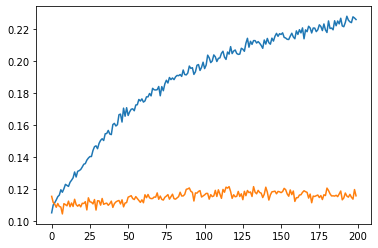

In [15]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

In [16]:
print("Test Accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Test Accuracy: 0.0019000000320374966
